In [2]:
from collections import Counter
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from nltk import word_tokenize
from nltk.corpus import stopwords

from wordcloud import WordCloud

import unidecode

In [3]:
df=pd.read_csv("salary_indeed.csv")

# Création Fonction Split Salary

In [4]:
def split_salary(row):
    salary = row["Salary"]
    if "-" in salary:
        split = salary.split("-")
        salary_min = split[0]
        salary_max = split[1]
    else:
        salary_min = salary
        salary_max = salary
    
    row["salary_min"] = salary_min.replace("€","")\
                                  .replace("par an","")\
                                  .replace("par mois","")\
                                  .replace("par semaine","")\
                                  .replace("par jour","")\
                                  .replace("par heure","")\
                                  .replace("\xa0","")
    row["salary_max"] = salary_max.replace("€","")\
                                  .replace("par an","")\
                                  .replace("par mois","")\
                                  .replace("par semaine","")\
                                  .replace("par jour","")\
                                  .replace("par heure","")\
                                  .replace("\xa0","")
    
    if "an" in row["Salary"]:
        row["salary_period"] = "year"

    if "mois" in row["Salary"]:
        if float(row["salary_min"]) < 1500:
            row["salary_min"] = float(row["salary_min"])
            row["salary_max"] = float(row["salary_max"])
            row["salary_period"] = "month"
        else:
            row["salary_min"] = float(row["salary_min"])*12
            row["salary_max"] = float(row["salary_max"])*12
            row["salary_period"] = "year"
    
    if "semaine" in row["Salary"]:
        row["salary_min"] = float(row["salary_min"])
        row["salary_max"] = float(row["salary_max"])
        row["salary_period"] = "week"

    if "jour" in row["Salary"]:
        row["salary_min"] = float(row["salary_min"])
        row["salary_max"] = float(row["salary_max"])
        row["salary_period"] = "day"

    if "heure" in row["Salary"]:
        row["salary_min"] = float(row["salary_min"].replace(",","."))
        row["salary_max"] = float(row["salary_max"].replace(",","."))
        row["salary_period"] = "hour"
        
    return row

# Création des colonnes salary max et salary min

In [5]:
stop_words = stopwords.words('french')

1. Mettre en minuscule
2. Remplacer les ponctuations (sauf '+') par des espaces : `[^\w|\s|+]` mais aussi les '|' et '\_' : `[_|\|]`
3. Remplacer les lettres accentuées par des lettres sans accents
4. Remplacer les lettres seules (sauf les lettres c et r (langages de programmation)) par des espaces : `\b[abd-qs-z]\b`
5. Remplacer les nombres qui ont 2 chiffres ou plus par des espaces : `\d{2,}`
6. Splitter la chaîne de caractères en une liste de mots
7. Créer une nouvelle liste sans les stopwords

In [6]:
def preprocessing_text(text, stopwords):
    text = text.lower()
    text = re.sub(r'[^\w|\s|+]', ' ', text)
    text = re.sub(r'[_|\|]', ' ', text)
    text = unidecode.unidecode(text)
    text = re.sub(r'\b[abd-qs-z]\b', ' ', text)
    text = re.sub(r'\d{2,}', ' ', text)

    # STOPWORDS
    tokenized_words = word_tokenize(text)
    tokenized_words = [word for word in tokenized_words if word not in stopwords]

    return tokenized_words

In [7]:
df_salary = df[~df.Salary.isna()]

df_salary = df_salary.apply(lambda column: column.apply(preprocessing_text, args=(stop_words,))
                                          if column.name in ['Title', 'Description']
                                          else column)

In [8]:
df_salary = df_salary.apply(split_salary, axis=1)
df_salary["salary_min"]=pd.to_numeric(df_salary["salary_min"],'coerce')
df_salary["salary_max"]=pd.to_numeric(df_salary["salary_max"],'coerce')

In [9]:
df_salary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744 entries, 8 to 4879
Data columns (total 12 columns):
_id                  744 non-null object
Title                744 non-null object
Company              744 non-null object
Location             744 non-null object
Salary               744 non-null object
Description          744 non-null object
Date                 597 non-null object
Job_Search           744 non-null object
Department_Search    744 non-null object
salary_min           744 non-null float64
salary_max           744 non-null float64
salary_period        744 non-null object
dtypes: float64(2), object(10)
memory usage: 75.6+ KB


## Création colonne salary mean

In [10]:
df_salary["salary_mean"] = (df_salary["salary_min"]+df_salary["salary_max"])/2

In [11]:
df_salary

,_id,Title,Company,Location,Salary,Description,Date,Job_Search,Department_Search,salary_min,salary_max,salary_period,salary_mean
8,p_008d77a008590232,"[ingenieur, developpeur, c++, java]",ALTEN,Toulouse (31),30 000 € - 45 000 € par an,"[partenaire, technologique, reference, plus, g...",08/09/2019,Développeur,Haute-Garonne,30000.0,45000.0,year,37500.0
15,p_00f2ad8db3c30b8e,[devops],Kent FR,Bordeaux (33),35 000 € - 40 000 € par an,"[kent, marque, groupagora, dediee, recrutement...",09/03/2019,Développeur,Gironde,35000.0,40000.0,year,37500.0
17,p_00fa03a21ad52a71,"[data, scientist]",QYSY,Paris (75),40 000 € - 65 000 € par an,"[qysy, cabinet, conseil, recrutementqui, propo...",29/09/2019,Data,75,40000.0,65000.0,year,52500.0
19,p_0130bef769eef3cc,"[business, developer, btob, data, intelligence]",L.I.P,Lyon 3e (69),35 000 € - 60 000 € par an,"[lyon, 3e, arrondissement, cdi, bac+5, plus, i...",07/10/2019,Data,Rhône,35000.0,60000.0,year,47500.0
31,p_019d01b7494dc632,"[referent, fonctionnel, donnees, data, manager]",GARCIN FINANCES ET PARTICIPATIONS,Corbas (69),40 000 € - 45 000 € par an,"[souhaitez, participer, structuration, donnees...",10/09/2019,Data,Rhône,40000.0,45000.0,year,42500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4871,pj_f9b2d5fe629ccfb3,[devops],EASY PARTNER,Paris (75),50 000 € - 55 000 € par an,"[poste, afin, accompagner, forte, croissance, ...",08/10/2019,Développeur,75,50000.0,55000.0,year,52500.0
4875,pj_fc87c600387c3e85,"[developpeur, java, back, end]",Gentis Recruitment SAS,Paris (75),50 € par heure,"[bonjour, client, startup, jeune, editeur, log...",NaN,Développeur,75,50.0,50.0,hour,50.0
4876,pj_fd8e78ca8bedfe98,"[web, developpeur]",CLERE / JES,Loire-Atlantique,22 000 € - 28 000 € par an,"[editeur, logiciels, developpons, interne, erp...",NaN,Développeur,Loire-Atlantique,22000.0,28000.0,year,25000.0
4877,pj_fe470d6a829fdecc,"[consultant, devops]",Des Systèmes et des Hommes,Paris 9e (75),45 000 € par an,"[docker, hibernate, linux, jenkins, oracle, cl...",NaN,Développeur,75,45000.0,45000.0,year,45000.0


# Je ne prends que les salaires qui sont 'par an' 

In [12]:
df_salary = df_salary[df_salary.salary_period == 'year']

## Quantiles salary min

In [13]:
df_salary.salary_min.describe()

count      675.000000
mean     40998.761481
std      10930.715767
min      20000.000000
25%      33000.000000
50%      40000.000000
75%      47500.000000
max      90000.000000
Name: salary_min, dtype: float64

## Quantiles salary max

In [14]:
df_salary.salary_max.describe()

count       675.000000
mean      49769.296296
std       13259.715155
min       20388.000000
25%       40000.000000
50%       50000.000000
75%       55000.000000
max      120000.000000
Name: salary_max, dtype: float64

## Quantiles salary mean

In [15]:
df_salary.salary_mean.describe()

count       675.000000
mean      45384.028889
std       11569.392983
min       20388.000000
25%       37500.000000
50%       45000.000000
75%       51250.000000
max      100000.000000
Name: salary_mean, dtype: float64

In [16]:
tercile_1 = np.quantile(df_salary.salary_mean, 1/3)
tercile_1

40000.0

In [17]:
tercile_2 = np.quantile(df_salary.salary_mean, 2/3)
tercile_2

48000.0

# Création colonne class label par rapport aux quantiles salary mean

In [18]:
def classification(x):
    if x <= tercile_1:
        label = 1
    elif x <= tercile_2:
        label = 2
    else:
        label = 3
    return label

df_salary["salary_label"] = df_salary["salary_mean"].apply(classification)

/Users/Ivan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [19]:
df_salary.head(10)

,_id,Title,Company,Location,Salary,Description,Date,Job_Search,Department_Search,salary_min,salary_max,salary_period,salary_mean,salary_label
8,p_008d77a008590232,"[ingenieur, developpeur, c++, java]",ALTEN,Toulouse (31),30 000 € - 45 000 € par an,"[partenaire, technologique, reference, plus, g...",08/09/2019,Développeur,Haute-Garonne,30000.0,45000.0,year,37500.0,1
15,p_00f2ad8db3c30b8e,[devops],Kent FR,Bordeaux (33),35 000 € - 40 000 € par an,"[kent, marque, groupagora, dediee, recrutement...",09/03/2019,Développeur,Gironde,35000.0,40000.0,year,37500.0,1
17,p_00fa03a21ad52a71,"[data, scientist]",QYSY,Paris (75),40 000 € - 65 000 € par an,"[qysy, cabinet, conseil, recrutementqui, propo...",29/09/2019,Data,75,40000.0,65000.0,year,52500.0,3
19,p_0130bef769eef3cc,"[business, developer, btob, data, intelligence]",L.I.P,Lyon 3e (69),35 000 € - 60 000 € par an,"[lyon, 3e, arrondissement, cdi, bac+5, plus, i...",07/10/2019,Data,Rhône,35000.0,60000.0,year,47500.0,2
31,p_019d01b7494dc632,"[referent, fonctionnel, donnees, data, manager]",GARCIN FINANCES ET PARTICIPATIONS,Corbas (69),40 000 € - 45 000 € par an,"[souhaitez, participer, structuration, donnees...",10/09/2019,Data,Rhône,40000.0,45000.0,year,42500.0,2
44,p_02074799b0dbc42e,"[developpeur, php, laravel]",Sept Lieues,Paris (75),32 000 € - 37 000 € par an,"[pme, pres, ans, existence, gestion, situation...",08/04/2019,Développeur,75,32000.0,37000.0,year,34500.0,1
49,p_02270c340e21e7ab,"[developpeur, windev]",Axemploi Recrutement,Nantes (44),30 000 € - 40 000 € par an,"[developpeur, windev, interviendrez, developpe...",18/09/2019,Développeur,Loire-Atlantique,30000.0,40000.0,year,35000.0,1
66,p_033110c9c03332f9,"[developpeur, java]",WOM,Lyon (69),30 000 € - 40 000 € par an,"[client, specialise, edition, logiciel, rse, r...",03/10/2019,Développeur,Rhône,30000.0,40000.0,year,35000.0,1
87,p_046189897fdb70ed,"[controleur, gestion, data, analyst]",SH Conseils,Paris 8e (75),35 000 € - 38 000 € par an,"[compte, operateur, telecoms, premier, plan, f...",18/09/2019,Data,75,35000.0,38000.0,year,36500.0,1
105,p_05b4d08c39d1a13c,"[developpeur, mobile, senior, ios, swift]",EXTERNATIC,Bordeaux (33),40 000 € - 50 000 € par an,"[description, offre, externatic, hub, opportun...",07/09/2019,Développeur,Gironde,40000.0,50000.0,year,45000.0,2


# Création des df par tranches label

In [20]:
label_1 = df_salary[df_salary["salary_label"]==1]
label_2 = df_salary[df_salary["salary_label"]==2]
label_3 = df_salary[df_salary["salary_label"]==3]

In [21]:
df_salary.Department_Search.value_counts(normalize=True) * 100

75                  55.851852
Rhône               17.925926
Loire-Atlantique     9.925926
Gironde              8.592593
Haute-Garonne        7.703704
Name: Department_Search, dtype: float64

In [22]:
df_salary.Job_Search.value_counts(normalize=True) * 100

Développeur    76.444444
Data           23.555556
Name: Job_Search, dtype: float64

In [23]:
label_1.Department_Search.value_counts(normalize=True) * 100

Rhône               27.985075
75                  22.761194
Loire-Atlantique    19.029851
Haute-Garonne       16.791045
Gironde             13.432836
Name: Department_Search, dtype: float64

In [24]:
label_1.Job_Search.value_counts(normalize=True) * 100

Développeur    89.179104
Data           10.820896
Name: Job_Search, dtype: float64

In [25]:
label_2.Department_Search.value_counts(normalize=True) * 100

75                  62.500000
Rhône               21.195652
Loire-Atlantique     7.065217
Gironde              7.065217
Haute-Garonne        2.173913
Name: Department_Search, dtype: float64

In [26]:
label_2.Job_Search.value_counts(normalize=True) * 100

Développeur    76.630435
Data           23.369565
Name: Job_Search, dtype: float64

In [27]:
label_3.Department_Search.value_counts(normalize=True) * 100

75                  90.134529
Gironde              4.035874
Rhône                3.139013
Loire-Atlantique     1.345291
Haute-Garonne        1.345291
Name: Department_Search, dtype: float64

In [28]:
label_3.Job_Search.value_counts(normalize=True) * 100

Développeur    60.986547
Data           39.013453
Name: Job_Search, dtype: float64

In [29]:
tag_title_1 = label_1["Title"]
tag_title_2 = label_2["Title"]
tag_title_3 = label_3["Title"]

In [30]:
# créer un dictionnaire avec la frequence de chaque mot de tag_title1
# on va ordonner par la valeur du dictionnaire en ordre descendant

result_1 = tag_title_1.apply(Counter).sum().items()
result_1 = sorted(result_1, key=lambda kv : kv[1], reverse=True)

result_2 = tag_title_2.apply(Counter).sum().items()
result_2 = sorted(result_2, key=lambda kv : kv[1], reverse=True)

result_3 = tag_title_3.apply(Counter).sum().items()
result_3 = sorted(result_3, key=lambda kv : kv[1], reverse=True)

### Je crée le dictionnaire qui associe la frequece de chaque mot sur chaque df

In [31]:
result_series_1 = dict(result_1)
result_series_2 = dict(result_2)
result_series_3 = dict(result_3)

In [32]:
result_series_1

{'developpeur': 205,
 'informatique': 36,
 'data': 32,
 'java': 29,
 'net': 26,
 'devops': 24,
 'php': 24,
 'ingenieur': 23,
 'web': 19,
 'junior': 17,
 'developpeurs': 15,
 'end': 14,
 'python': 13,
 'front': 12,
 'cdi': 11,
 'c++': 10,
 'fullstack': 10,
 'symfony': 9,
 'concepteur': 8,
 'full': 8,
 'stack': 8,
 'angular': 7,
 'sql': 7,
 'scientist': 7,
 'mobile': 7,
 'windev': 6,
 'applications': 6,
 'back': 6,
 'senior': 6,
 'android': 6,
 'lyon': 5,
 'consultant': 5,
 'logiciel': 5,
 'experimente': 5,
 'technicien': 5,
 'ios': 5,
 'j2ee': 4,
 'reseaux': 4,
 'editeur': 4,
 'js': 4,
 'big': 4,
 'integrateur': 4,
 'javascript': 4,
 'asp': 4,
 'react': 4,
 'analyst': 3,
 'client': 3,
 'final': 3,
 'engineer': 3,
 'seniors': 3,
 'spatial': 3,
 'industrielle': 3,
 'sig': 3,
 'vba': 3,
 'developpeuse': 3,
 'center': 3,
 'confirme': 3,
 'nantes': 3,
 'magento': 3,
 'paris': 3,
 'controleur': 2,
 'gestion': 2,
 'produit': 2,
 'administrateur': 2,
 'systeme': 2,
 'bi': 2,
 'jee': 2,
 'euse':

# Visualisation du wordcloud title de chaque df

In [33]:
wordcloud_1 = WordCloud(max_words=50).generate_from_frequencies(result_series_1)
wordcloud_2 = WordCloud(max_words=50).generate_from_frequencies(result_series_2)
wordcloud_3 = WordCloud(max_words=50).generate_from_frequencies(result_series_3)

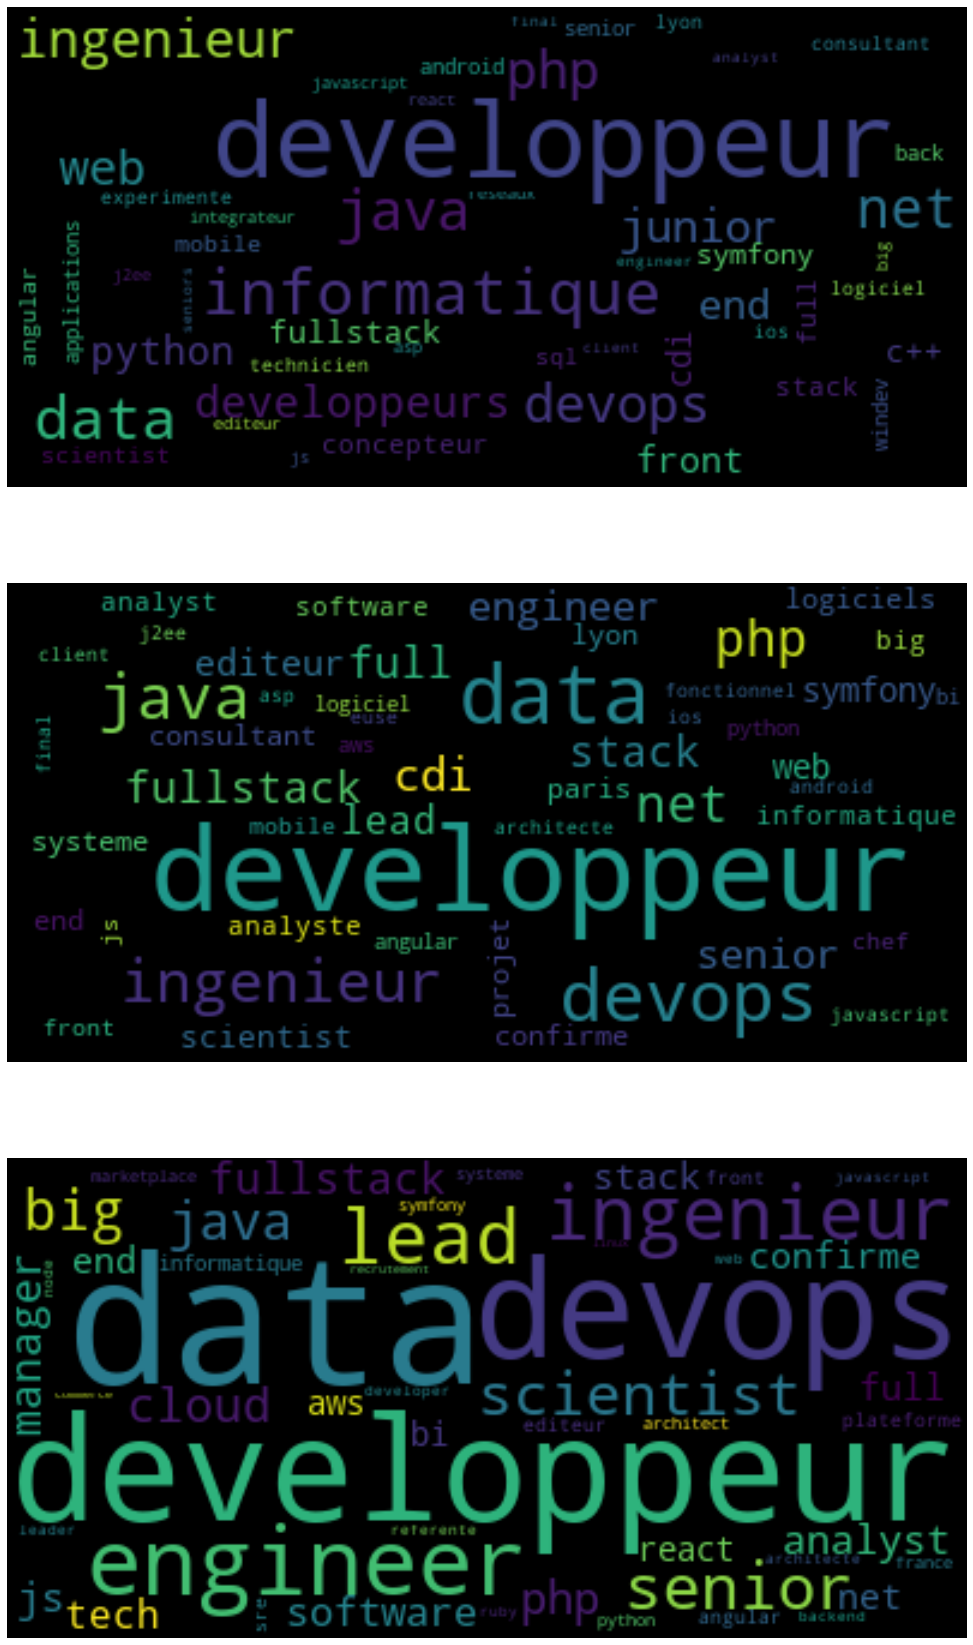

In [34]:
plt.figure(figsize = (25, 30))

plt.subplot(3, 1, 1)
plt.imshow(wordcloud_1, interpolation="bilinear")
plt.axis("off")

plt.subplot(3, 1, 2)
plt.imshow(wordcloud_2, interpolation="bilinear")
plt.axis("off")

plt.subplot(3, 1, 3)
plt.imshow(wordcloud_3, interpolation="bilinear")
plt.axis("off")
plt.show()

In [35]:
tag_desc_1 = label_1["Description"]
tag_desc_2 = label_2["Description"]
tag_desc_3 = label_3["Description"]

In [36]:
tag_desc_3

17      [qysy, cabinet, conseil, recrutementqui, propo...
134     [data, ops, engineer, paris, france, k, an, cr...
136     [ingenieur, systeme, opensource, devops, poste...
230     [startup, developpe, plateforme, machine, lear...
241     [description, offre, externatic, hub, opportun...
                              ...                        
4836    [depuis, creation, groupe, alliance, consultan...
4842    [sharp, azure, asp, net, devops, manager, cdi,...
4865    [areas, data, science, media, effectiveness, r...
4871    [poste, afin, accompagner, forte, croissance, ...
4879    [r, python, adobe, analytics, at, internet, go...
Name: Description, Length: 223, dtype: object

# création des dictionnaires qui à chaque mot associe sa frequence

In [37]:
desc_1 = tag_desc_1.apply(Counter).sum().items()
desc_1 = sorted(desc_1, key=lambda kv : kv[1], reverse=True) 
dict_desc_1 = {k: v for k,v in desc_1}

desc_2 = tag_desc_2.apply(Counter).sum().items()
desc_2 = sorted(desc_2, key=lambda kv : kv[1], reverse=True) 
dict_desc_2 = {k: v for k,v in desc_2}

desc_3 = tag_desc_3.apply(Counter).sum().items()
desc_3 = sorted(desc_3, key=lambda kv : kv[1], reverse=True) 
dict_desc_3 = {k: v for k,v in desc_3}

# Visualisation du wordcloud job_desc pour chaque df

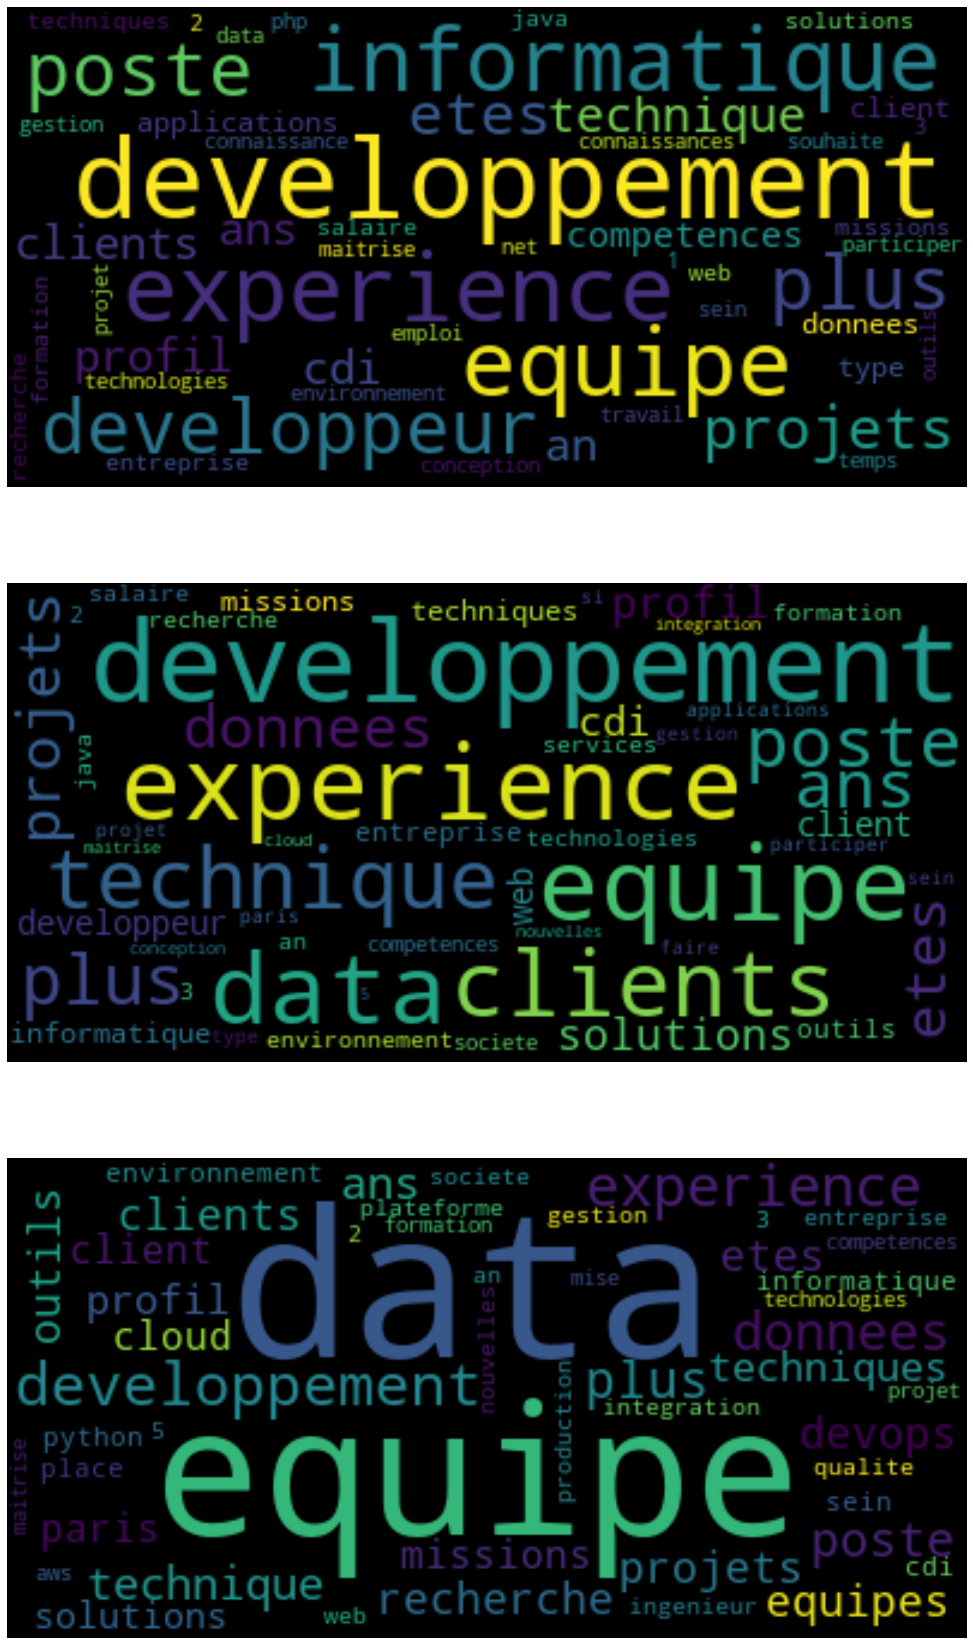

In [38]:
wordcloud6 = WordCloud(max_words=50).generate_from_frequencies(dict_desc_1)
wordcloud7 = WordCloud(max_words=50).generate_from_frequencies(dict_desc_2)
wordcloud8 = WordCloud(max_words=50).generate_from_frequencies(dict_desc_3)

figure = plt.figure(figsize = (25, 30))
plt.figure(1)
plt.subplot(3, 1, 1)
plt.imshow(wordcloud6, interpolation="bilinear")
plt.axis("off")

plt.subplot(3, 1, 2)
plt.imshow(wordcloud7, interpolation="bilinear")
plt.axis("off")

plt.subplot(3, 1, 3)
plt.imshow(wordcloud8, interpolation="bilinear")
plt.axis("off")

plt.show()

## prediction salaire avec job desc brut seulement

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [40]:
X_desc = df_salary.Description.apply(" ".join)
y = df_salary.salary_label

In [41]:
X_desc

8       partenaire technologique reference plus grande...
15      kent marque groupagora dediee recrutements pro...
17      qysy cabinet conseil recrutementqui propose re...
19      lyon 3e arrondissement cdi bac+5 plus ingenieu...
31      souhaitez participer structuration donnees usa...
                              ...                        
4865    areas data science media effectiveness roi mar...
4871    poste afin accompagner forte croissance souci ...
4876    editeur logiciels developpons interne erp modu...
4877    docker hibernate linux jenkins oracle cloud de...
4879    r python adobe analytics at internet google an...
Name: Description, Length: 675, dtype: object

In [42]:
vectorizer = TfidfVectorizer(ngram_range=(1, 4))
vectorizer.fit(X_desc)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 4), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [43]:
len(vectorizer.get_feature_names())

261448

In [44]:
X_desc_trans = pd.DataFrame(vectorizer.transform(X_desc).todense(), columns=vectorizer.get_feature_names())
X_desc_trans

,1er,1er arrondissement,1er arrondissement paris,1er arrondissement paris package,1er arrondissement terreaux,1er arrondissement terreaux cette,1er europe,1er europe fournir,1er europe fournir tout,1er niveaux,...,zwave competences,zwave competences requises,zwave competences requises expert,zwave wi,zwave wi fi,zwave wi fi ethernet,zxtm,zxtm serveurs,zxtm serveurs proxy,zxtm serveurs proxy squid
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
import numpy as np
np.asmatrix(X_desc_trans)

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
word_counts = X_desc_trans.sum(axis=0)
word_counts.sort_values(ascending = False).head(20)

data             11.661502
developpement    10.741107
equipe            9.057846
experience        7.874841
donnees           7.156053
technique         6.607971
etes              6.606878
plus              6.481354
poste             6.345815
clients           6.325732
projets           6.180537
ans               6.023120
informatique      5.924572
developpeur       5.849228
java              5.583230
client            5.496827
web               5.364540
techniques        5.343898
solutions         5.310510
outils            5.231133
dtype: float64

In [47]:
X_train, X_test, y_train, y_test = train_test_split(np.asmatrix(X_desc_trans), y, stratify=y)

In [48]:
rfc = RandomForestClassifier(n_estimators=5, random_state=42)
rfc.fit(X_train, y_train)

rfc.score(X_test,y_test)

0.5976331360946746

In [49]:
rfc.score(X_train, y_train)

0.9446640316205533

In [50]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_desc_trans.columns).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_importances.sort_values('importance', ascending=False).head(30)

,feature,importance
101206,experience developpeur,0.009840
143189,logiciels,0.008933
85225,emploi cdi salaire,0.007485
40361,client,0.006362
42585,cloud,0.005980
129541,integrer,0.005796
33458,cahier charges,0.005335
47143,competences egales toutes,0.005192
95157,etc,0.005162
192457,produit,0.004898


# Prédiction salaire avec Title seulement

In [51]:
X_title = df_salary.Title.apply(" ".join)
y = df_salary.salary_label

In [52]:
vectorizer_2 = TfidfVectorizer(ngram_range=(1, 4))
vectorizer_2.fit(X_title)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 4), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [53]:
len(vectorizer_2.get_feature_names())

2735

In [54]:
X_title_trans = pd.DataFrame(vectorizer_2.transform(X_title).todense(), columns=vectorizer_2.get_feature_names())
X_title_trans

,2d,2d 3d,3d,3d rm,3d rm ra,3d rm ra hololens,3d unity,3d unity 3d,3d unity 3d rm,accepte,...,web net,web paris,web sig,web sig experimente,windev,windev pc,windev pc soft,windows,windows devops,xamarin
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
word_counts2 = X_title_trans.sum(axis=0)
word_counts2.sort_values(ascending = False).head(20)

developpeur                 58.171379
devops                      35.734575
data                        32.526052
java                        21.017039
ingenieur                   20.850207
developpeur java            19.024475
engineer                    16.864850
net                         16.711424
php                         15.198750
informatique                14.448319
data engineer               13.952672
scientist                   13.433784
data scientist              13.433784
developpeur php             13.429881
ingenieur devops            12.893268
developpeur informatique    12.726635
developpeur net             12.709495
web                         10.935123
lead                        10.383333
senior                      10.254226
dtype: float64

In [56]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(np.asmatrix(X_title_trans), y, random_state=42, stratify=y)

In [57]:
rfc = RandomForestClassifier(7, random_state=42)
rfc.fit(X_train2, y_train2)

rfc.score(X_test2,y_test2)

0.5562130177514792

In [58]:
rfc.score(X_train2,y_train2)

0.8715415019762845

In [59]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_title_trans.columns).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_importances.sort_values('importance', ascending=False).head(20)

,feature,importance
610,developpeur,0.096894
1021,devops,0.025690
433,data,0.019176
994,developpeurs,0.018215
1216,engineer,0.016203
756,developpeur informatique,0.015227
294,cdi,0.014267
2372,senior,0.012891
790,developpeur java,0.011268
1703,java,0.010556
